<a href="https://colab.research.google.com/github/ridhimagarg/PyTorchBook/blob/main/Chapter04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import random
import numpy as np
from PIL import Image

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler, SubsetRandomSampler
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage, RandomHorizontalFlip, Resize

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

# from data_generation.image_classification import generate_dataset
from image_classification import generate_dataset ##  if working on  colab 
from v0 import StepByStep
# from plot.chapter4 import * 
from chapter4 import *
# from stepbystep.v0 import StepByStep

## Data Generation

In [8]:
## lets generate 300
images, labels = generate_dataset(img_size=5, n_images=300, seed=13)

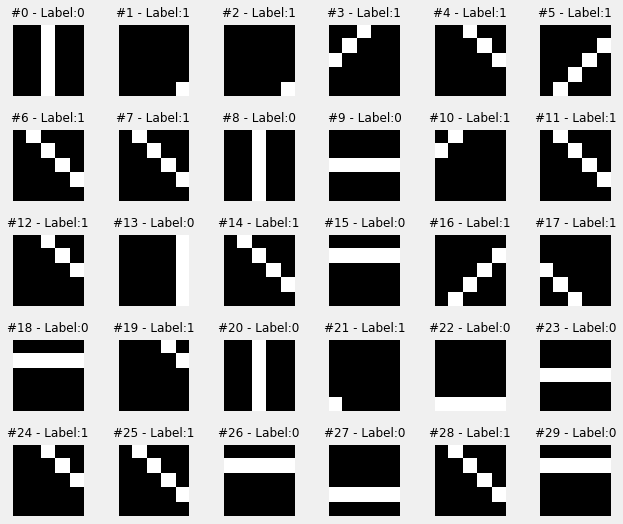

In [11]:
fig = plot_images(images, labels, n_plot=30)